# BMME 890 - Initial Project Presentation
Group Members: Joey Richardson, Keita Yokoyama, Keerthi Anand, Katie Heath

## Background

### Predicting tissue mechanical properties with Ultrasound VisR technicque using Machine Learning

#### Elastography
A method of quantifying the mechanical properties of tissue using ultrasound. We use a VISR, or viscoelatic response Imaging to accomplish this. VISR uses a method of ultrasound imaging called ARFI.

ARFI, or acoustic radiation force imaging, pushes on tissue with strong ultrasound waves. These waves displace the tissue, allowing us to track how the tissue moves over time. 
<div><img src="presentation_images\visrML1\fig01-whatIsARFI.gif" style="width:400px"></div>

VISR uses two ARFI pulses,  to displace tissue at a single location.  Using these displacement curves, we can calculate the the relative elasticity and viscosity in tissue.
<div><img src="presentation_images\visrML1\fig02-whatIsVisR.gif" style="width:400px"></div>

#### Quantitative vs Qualitative
Because the many different layers of tissue the waves must pass through to reach the target organ vary in their sound propogating properties, we cannot directly calculate the value of elasticity and viscosity. 
<div><img src="presentation_images\visrML1\fig03-normalVisrQualitative.png" style="width:400px"></div>

We want to use machine learning to find the absolute value of Young's modulus and viscous modulus.
<div><img src="presentation_images\visrML1\fig04-proposed.png" style="width:400px"></div>

Ideally, we would input "displacement profiles", or time-series-based ultrasound data for a line of different positions.
<div><img src="presentation_images\visrML1\fig05-bestParam.png" style="width:400px"></div>

...ideally, because we didn't have time to make that work.
Instead, we pulled out singular values from that displacement data for each material. The values are:
<div><img src="presentation_images\visrML1\fig06-paramBad.png" style="width:400px"></div>

Given all of this, we structured our ML algorithms like this:
<div><img src="presentation_images\visrML1\fig07-method.png" style="width:400px"></div>

# Load Sample Data

In [5]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import os
mypath = 'C:/Users/Keerthi Anand/Documents/bmme890/mldata'

#Choose Parameters of Interest
focal_depth=15
elasticity=15.56
viscosity=7.01
seed=0

#Load Variables From File
filename='data_'+str(focal_depth)+'_'+str(elasticity)+'_'+str(viscosity)+'_'+str(seed)+'.mat'
print(os.getcwd())
mat = loadmat(mypath+'/matfiles/'+filename)  # load mat-file
arfidata = mat['arfidata'] 
axial = mat['axial']
t=np.arange(0, arfidata.shape[1]*(1e-4), 1e-4)


C:\Users\Keerthi Anand\Documents\bmme890\mldata


# Display Sample Data

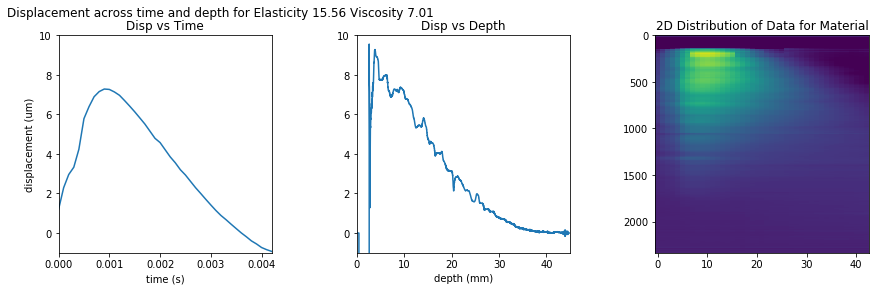

In [6]:

plt.subplot(131)
plt.plot(t,arfidata[500,:])
plt.ylabel('displacement (um)')
plt.xlabel('time (s)')
plt.axis([0, .0042, -1, 10])
plt.title('Disp vs Time')
plt.subplot(132)
plt.plot(axial,arfidata[:,10])
plt.xlabel('depth (mm)')
plt.axis([0, 45, -1, 10])
plt.title('Disp vs Depth')
plt.subplot(133)
plt.imshow(arfidata,aspect='auto',vmin=-1,vmax=10,resample=1)
plt.title('2D Distribution of Data for Material')
plt.suptitle('Displacement across time and depth for Elasticity '+str(elasticity)+' Viscosity '+str(viscosity))
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=.4, hspace=None)
plt.show()


# Compute Relevant Parameters

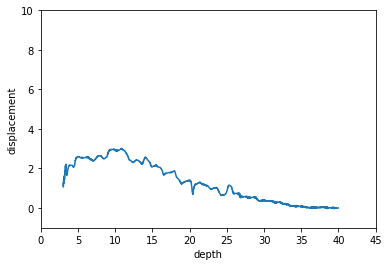

In [7]:
# Only retain data between depths 5 mm and 40 mm
mindepth=3;
maxdepth=40;
idx1 = (np.abs(axial - mindepth)).argmin()
idx2 = (np.abs(axial - maxdepth)).argmin()
axialnew=axial[idx1:idx2];
arfidatanew=arfidata[idx1:idx2,:]
plt.plot(axialnew,arfidatanew[:,2])
plt.ylabel('displacement')
plt.xlabel('depth')
plt.axis([0, 45, -1, 10])
plt.show()

# Calculate Important Parameters from Data

Max(PD) is 9.282269296401221 um at depth of 3.79225 mm and time of 0.001


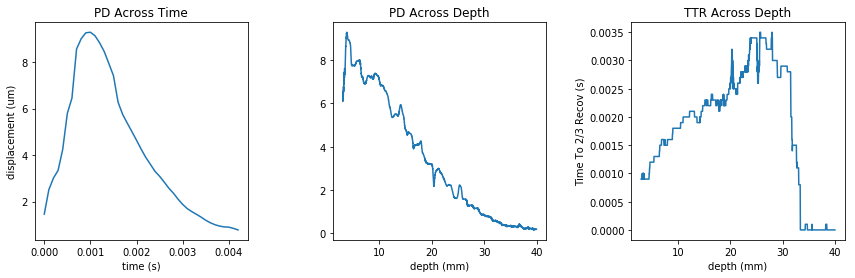

In [8]:
#Peak displacement across time
PDbytime=np.amax(arfidatanew,0)
plt.subplot(131)
plt.plot(t,PDbytime)
plt.ylabel('displacement (um)')
plt.xlabel('time (s)')
plt.title('PD Across Time')

#Peak displacement across depth
PDbydepth=np.amax(arfidatanew,1)
plt.subplot(132)
plt.plot(axialnew,PDbydepth)
plt.xlabel('depth (mm)')
plt.title('PD Across Depth')

#Single peak displacement values through time and depth
PD=np.amax(PDbydepth,0)
PDind=((np.abs(PDbydepth - PD)).argmin())
#PDloc=PDbydepth[PDind];
PDloc=axialnew[PDind][0]
PDind=((np.abs(PDbytime - PD)).argmin())
#PDtm=PDbytime[PDind];
PDtm=t[PDind]
print('Max(PD) is '+str(PD)+' um at depth of '+str(PDloc)+' mm and time of '+str(PDtm))

#Time to 2/3 recovery for each depth
TTR=np.zeros((PDbydepth.shape[0]))
for y in range(arfidatanew.shape[0]):
    
    tempdata=arfidatanew[y,:]
    tempdata=tempdata[ ((np.abs(tempdata - PDbydepth[y])).argmin()):tempdata.shape[0]]
    tempdata=tempdata[0:((np.abs(tempdata - PDbydepth[y]/3)).argmin())]
    TTR[y]=(tempdata.shape[0])*1e-4;
    
plt.subplot(133)
plt.plot(axialnew,TTR)
plt.ylabel('Time To 2/3 Recov (s)')
plt.xlabel('depth (mm)')
plt.title('TTR Across Depth')
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=.4, hspace=None)
plt.show()

# Save Preprocessed Data to .mat File

In [9]:
from scipy.io import savemat
savemat(mypath+'/matfiles_clnprep/'+filename,{
    'focal_depth': np.float32(focal_depth),
    'elasticity': np.float32(elasticity),
    'viscosity': np.float32(viscosity),
    'seed': np.float32(seed),
    'axial': axialnew,
    't': t,'TTR': TTR,
    'PDbydepth': PDbydepth,
    'PDbytime': PDbytime,
    'PD': PD,
    'PDloc': PDloc,
    'PDtm': PDtm})

# Create Data Frame

In [10]:
dfsmall = pd.DataFrame(columns=['focal_depth','elasticity','viscosity','medianTTR','maxPD','maxPDloc','maxPDtm','seed']) # from lists of dicts
dfsmall.astype('float32').dtypes
print(dfsmall)
dftime = pd.DataFrame(columns=['focal_depth','elasticity','viscosity','depth','t','TTR','maxPD','PD','seed']) # from lists of dicts
print(dftime)

Empty DataFrame
Columns: [focal_depth, elasticity, viscosity, medianTTR, maxPD, maxPDloc, maxPDtm, seed]
Index: []
Empty DataFrame
Columns: [focal_depth, elasticity, viscosity, depth, t, TTR, maxPD, PD, seed]
Index: []


# Repeat For All 1000 Combinations of Focal Depths, Elasticities, Viscosities, and Seeds

In [11]:
from os import listdir
from os.path import isfile, join
from scipy.io import savemat
import json
import timeit
import statistics as stat

start = timeit.default_timer()

listdict = []
onlyfiles = [f for f in listdir(mypath+'/matfiles/') if isfile(join(mypath+'/matfiles/', f))]
i=0;
filesarray=np.array(onlyfiles)

for f in onlyfiles:
    # print(f)
    # print(i)
    f2 = f[:-4]
    focal_depth=f2.split('_')[1]
    elasticity=f2.split('_')[2]
    viscosity=f2.split('_')[3]
    seed=f2.split('_')[4]
 
    # Load
    mat = loadmat(mypath+'/matfiles/'+f)  # load mat-file
    arfidata = mat['arfidata'] 
    axial = mat['axial']
    t=np.arange(0, arfidata.shape[1]*(1e-4), 1e-4)
    
    # Clean
    mindepth=5;
    maxdepth=30;
    idx1 = (np.abs(axial - mindepth)).argmin()
    idx2 = (np.abs(axial - maxdepth)).argmin()
    axialnew=axial[idx1:idx2];
    arfidatanew=arfidata[idx1:idx2,:]
    
    #Calculate
    PDbytime=np.amax(arfidatanew,0)
    PD=np.amax(PDbytime,0)
    PDind=((np.abs(PDbytime - PD)).argmin())
    #PDtm=PDbytime[PDind];
    PDtm = t[PDind];
    
    PDbydepth=np.amax(arfidatanew,1)
    PD=np.amax(PDbydepth,0)
    PDind=((np.abs(PDbydepth - PD)).argmin())
    #PDloc=PDbydepth[PDind];
    PDloc=axialnew[PDind][0];
    
    """
    Not working 
    pd.concat([pd.DataFrame([focal_depth, elasticity, viscosity,PD,PDtime[tm],t[tm],seed], 
                            columns=['focal_depth','elasticity','viscosity','maxPD','PD','t','seed']) for tm in range(PDtime.shape[0])],
                            ignore_index=True)
    
    """
    
    """
    Inefficient?
    for tm in range(PDtime.shape[0]):
        df = df.append({'focal_depth':focal_depth,
                        'elasticity':elasticity,
                        'viscosity':viscosity,
                        'maxPD':PD,
                        'PD':PDtime[tm],
                        't':t[tm],
                        'seed':seed}, ignore_index=True)
    """

    
    TTR=np.zeros((PDbydepth.shape[0]))
    for y in range(arfidatanew.shape[0]):

        tempdata=arfidatanew[y,:]
        tempdata=tempdata[ ((np.abs(tempdata - PDbydepth[y])).argmin()):tempdata.shape[0]]
        tempdata=tempdata[0:((np.abs(tempdata - PDbydepth[y]/3)).argmin())]
        TTR[y]=(tempdata.shape[0])*1e-4;
        
        """
        Inefficient?
        df = df.append({'focal_depth':focal_depth,
                        'elasticity':elasticity,
                        'viscosity':viscosity,
                        'TTR':TTR[y],
                        'maxPD':PD,
                        'PD':PDdepth[y],
                        'depth':axialnew[y],
                        'seed':seed}, ignore_index=True)
       
        """
        
    # Save
    dfsmall=dfsmall.append({'focal_depth':np.float32(focal_depth),
                        'elasticity':np.float32(elasticity),
                        'viscosity':np.float32(viscosity),
                        'medianTTR':stat.median(TTR),
                        'maxPD':PD,
                        'maxPDtm':PDtm,
                        'maxPDloc':PDloc,
                        'seed':np.float32(seed)}, ignore_index=True)
    
    savemat(mypath+'/matfiles_clnprep/'+f,{
        'refID': i,
        'focal_depth': np.float32(focal_depth),
        'elasticity': np.float32(elasticity),
        'viscosity': np.float32(viscosity),
        'seed': np.float32(seed),
        'axial': axialnew,
        't': t,
        'TTR': TTR,
        'medianTTR':stat.median(TTR),
        'PDbydepth': PDbydepth,
        'PDbytime': PDbytime,
        'maxPD': PD,
        'maxPDloc': PDloc,
        'maxPDtm': PDtm})
    
    
    
    
    
    listdict.append({'refID': i, 'filename': f, 'focal_depth': focal_depth, 'elasticity': elasticity, 'viscosity': viscosity, 'seed': seed})
    i+=1
    
dfsmall.to_pickle('FD15_100Materials10Seeds.pkl')

with open('VISRmetadata.json', 'w') as fout:
    json.dump(listdict, fout)
   

stop = timeit.default_timer()
print('Time: ', stop - start)  


Time:  29.405607180999993


In [12]:
PDbytime=np.amax(arfidatanew,0)
PDt=np.amax(PDbytime,0)
PDindt=((np.abs(PDbytime - PDt)).argmin())
PDtm=PDbytime[PDindt];
PDbydepth=np.amax(arfidatanew,1)
PDd=np.amax(PDbydepth,0)
PDindd=((np.abs(PDbydepth - PDd)).argmin()) 
PDloc=PDbydepth[PDindd];

dfsmall.describe()

,focal_depth,elasticity,viscosity,medianTTR,maxPD,maxPDloc,maxPDtm,seed
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,15.0,52.500000,3.510000,0.001233,6.464019,6.570295,0.000774,4.500000
std,0.0,30.332535,2.234187,0.000639,3.972561,1.044765,0.000290,2.873719
min,15.0,5.000000,0.010000,0.000600,2.842485,5.005000,0.000500,0.000000
25%,15.0,26.110001,1.570000,0.000800,3.753059,5.948250,0.000600,2.000000
50%,15.0,52.500000,3.510000,0.000950,4.898062,6.429500,0.000700,4.500000
75%,15.0,78.889999,5.450000,0.001400,7.678418,7.084000,0.000800,7.000000
max,15.0,100.000000,7.010000,0.003100,23.804202,10.799250,0.001700,9.000000


# Check For Any Initial Patterns in Data

(1000, 8)
     focal_depth  elasticity  viscosity  medianTTR      maxPD  maxPDloc  \
626         15.0         5.0       1.57     0.0030  18.509325   7.16100   
627         15.0         5.0       1.57     0.0030  18.802330   5.83275   
628         15.0         5.0       1.57     0.0030  18.281517   5.10125   
629         15.0         5.0       1.57     0.0030  19.949163   7.08400   
630         15.0         5.0       2.34     0.0030  16.290776   6.17925   
631         15.0         5.0       2.34     0.0029  17.100932   5.00500   
632         15.0         5.0       2.34     0.0030  16.144632   5.00500   
633         15.0         5.0       2.34     0.0029  18.269729   6.93000   
634         15.0         5.0       2.34     0.0029  16.112102   5.25525   
635         15.0         5.0       2.34     0.0029  15.845144   6.42950   
636         15.0         5.0       2.34     0.0029  17.412148   7.16100   
637         15.0         5.0       2.34     0.0029  17.727124   5.85200   
638         15.

Text(0.5, 1.0, 'True Elasticity vs Measured PD')

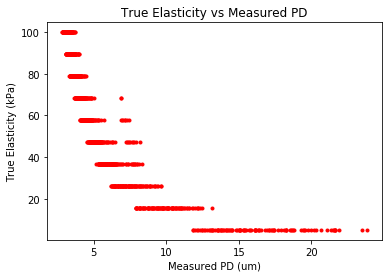

In [17]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd

# Output Summary
# print(dfsmall.memory_usage())

dfsmall = pd.read_pickle('FD15_100Materials10Seeds.pkl')
dfsmall=dfsmall.sort_values('elasticity')
print(dfsmall.shape)
print(dfsmall.head(20))
# dfsmall.to_pickle('FD15_100Materials10Seeds.pkl')

allelasts=dfsmall.elasticity
allmaxPD=dfsmall.maxPD



plt.plot(allmaxPD, allelasts, '.', color='red');
plt.ylabel('True Elasticity (kPa)')
plt.xlabel('Measured PD (um)')
plt.title('True Elasticity vs Measured PD')

# Look Elasticity vs PD For Only One Viscosity (1.57) And One Seed

(10, 8)


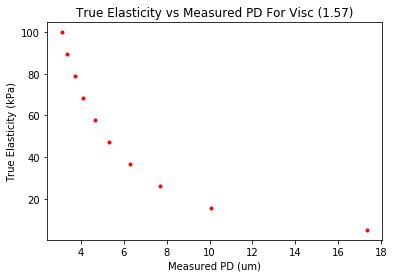

In [18]:
dfsmall_1p57visc=dfsmall[((dfsmall.viscosity == np.float32(1.57)) & (dfsmall.seed == np.float32(0)))]
print(dfsmall_1p57visc.shape)
elastswvisc1p57=dfsmall_1p57visc.elasticity
maxPDwvisc1p57=dfsmall_1p57visc.maxPD
plt.plot(maxPDwvisc1p57, elastswvisc1p57, '.', color='red');
plt.ylabel('True Elasticity (kPa)')
plt.xlabel('Measured PD (um)')
plt.title('True Elasticity vs Measured PD For Visc (1.57)')
plt.show()

# Look At Viscosity vs PD 

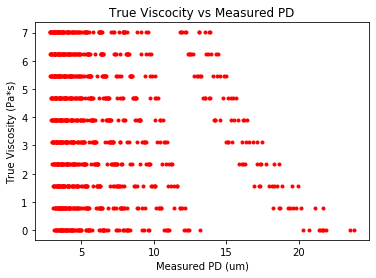

In [19]:
allviscs=dfsmall.viscosity
allmaxPD=dfsmall.maxPD
plt.plot(allmaxPD, allviscs, '.', color='red');
plt.ylabel('True Viscosity (Pa*s)')
plt.xlabel('Measured PD (um)')
plt.title('True Viscocity vs Measured PD')
plt.show()

# Look At Viscosity vs PD For One Elasticity (26.11) And One Seed

(10, 8)


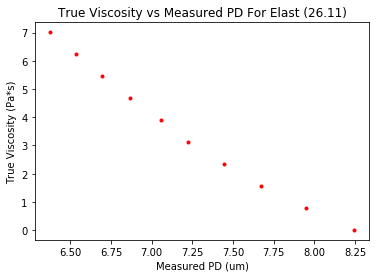

In [20]:
dfsmall_26p11elast=dfsmall[((dfsmall.elasticity == np.float32(26.11)) & (dfsmall.seed == np.float32(0)))]
print(dfsmall_26p11elast.shape)
viscsw26p11elast=dfsmall_26p11elast.viscosity
maxPDw26p11elast=dfsmall_26p11elast.maxPD
plt.plot(maxPDw26p11elast, viscsw26p11elast, '.', color='red');
plt.ylabel('True Viscosity (Pa*s)')
plt.xlabel('Measured PD (um)')
plt.title('True Viscosity vs Measured PD For Elast (26.11)')
plt.show()

# Look At Viscosity vs Median TTR

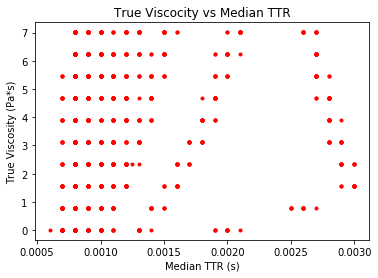

In [21]:
allviscs=dfsmall.viscosity
allmedTTR=dfsmall.medianTTR
plt.plot(allmedTTR, allviscs, '.', color='red');
plt.ylabel('True Viscosity (Pa*s)')
plt.xlabel('Median TTR (s)')
plt.title('True Viscocity vs Median TTR')
plt.show()

# Look At Viscosity vs Median TTR For One Elasticity (57.78) And One Seed

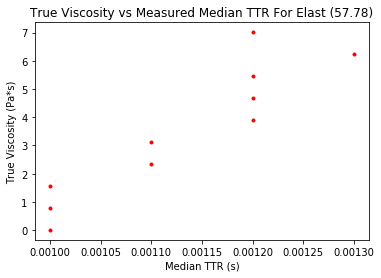

In [22]:
dfsmall_57p78elast=dfsmall[((dfsmall.elasticity == np.float32(36.67)) & (dfsmall.seed == np.float32(0)))]
viscsw57p78elast=dfsmall_57p78elast.viscosity
medTTRw57p78elast=dfsmall_57p78elast.medianTTR
plt.plot(medTTRw57p78elast, viscsw57p78elast, '.', color='red');
plt.ylabel('True Viscosity (Pa*s)')
plt.xlabel('Median TTR (s)')
plt.title('True Viscosity vs Measured Median TTR For Elast (57.78)')
plt.show()

# Look at Elasticity vs Median TTR

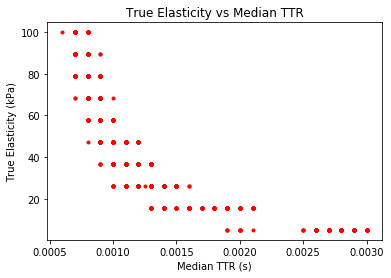

In [23]:
allelasts=dfsmall.elasticity
allmedTTR=dfsmall.medianTTR
plt.plot(allmedTTR, allelasts, '.', color='red');
plt.ylabel('True Elasticity (kPa)')
plt.xlabel('Median TTR (s)')
plt.title('True Elasticity vs Median TTR')
plt.show()

# Look Elasticity vs TTR For Only One Viscosity (1.57) And One Seed

(10, 8)


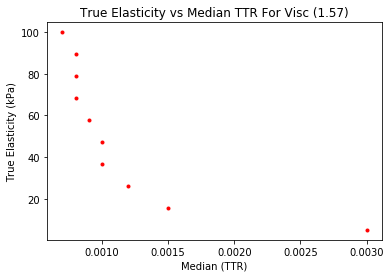

In [24]:
dfsmall_1p57visc=dfsmall[((dfsmall.viscosity == np.float32(1.57)) & (dfsmall.seed == np.float32(0)))]
print(dfsmall_1p57visc.shape)
elastswvisc1p57=dfsmall_1p57visc.elasticity
medTTRwvisc1p57=dfsmall_1p57visc.medianTTR
plt.plot(medTTRwvisc1p57, elastswvisc1p57, '.', color='red');
plt.ylabel('True Elasticity (kPa)')
plt.xlabel('Median (TTR)')
plt.title('True Elasticity vs Median TTR For Visc (1.57)')
plt.show()

## Imports

In [1]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat, savemat
import sys, os, json, timeit, sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import statistics as stat
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Read data
Currently were only able to run the processing algorithm for a single focal depth so this column is a constant </br>

In [25]:
df_original = pd.read_pickle('FD15_100Materials10Seeds.pkl')
df = df_original.copy()
df.drop(['focal_depth'], inplace=True, axis=1)
df.head()

,elasticity,viscosity,medianTTR,maxPD,maxPDloc,maxPDtm,seed
0,100.0,0.01,0.0007,3.276136,6.73750,0.0006,0.0
1,100.0,0.01,0.0008,3.367805,6.04450,0.0006,1.0
2,100.0,0.01,0.0007,3.603597,6.62200,0.0006,2.0
3,100.0,0.01,0.0007,3.523998,6.87225,0.0006,3.0
4,100.0,0.01,0.0007,3.457674,8.52775,0.0005,4.0


In [34]:
df.describe()

,elasticity,viscosity,medianTTR,maxPD,maxPDloc,maxPDtm,seed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,52.500000,3.510000,12.059500,6.464019,6.570295,7.736000,4.500000
std,30.332535,2.234187,5.906827,3.972561,1.044765,2.901849,2.873719
min,5.000000,0.010000,6.000000,2.842485,5.005000,5.000000,0.000000
25%,26.110001,1.570000,8.000000,3.753059,5.948250,6.000000,2.000000
50%,52.500000,3.510000,10.000000,4.898062,6.429500,7.000000,4.500000
75%,78.889999,5.450000,13.000000,7.678418,7.084000,8.000000,7.000000
max,100.000000,7.010000,30.000000,23.804202,10.799250,17.000000,9.000000


## Prepare Data for Machine Learning
- Time data is measured in fractions of a second so it needs to be scaled

In [26]:
df['medianTTR'] = df['medianTTR']*10000
df['maxPDtm'] = df['maxPDtm']*10000
df.describe()

,elasticity,viscosity,medianTTR,maxPD,maxPDloc,maxPDtm,seed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,52.500000,3.510000,12.059500,6.464019,6.570295,7.736000,4.500000
std,30.332535,2.234187,5.906827,3.972561,1.044765,2.901849,2.873719
min,5.000000,0.010000,6.000000,2.842485,5.005000,5.000000,0.000000
25%,26.110001,1.570000,8.000000,3.753059,5.948250,6.000000,2.000000
50%,52.500000,3.510000,10.000000,4.898062,6.429500,7.000000,4.500000
75%,78.889999,5.450000,13.000000,7.678418,7.084000,8.000000,7.000000
max,100.000000,7.010000,30.000000,23.804202,10.799250,17.000000,9.000000


## Split Data
Trying to predict elasticity initially - y </br>
Remaining values become the training data - X

In [35]:
from sklearn.model_selection import train_test_split
predictor = 'elasticity'
if predictor == 'elasticity':
    X = df.drop([predictor, 'viscosity'], axis=1)
    y = df[predictor]
elif predictor == 'viscosity':
    X = df.drop([predictor, 'elasticity'], axis=1)
    y = df[predictor]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X train shape:  (800, 5)
Y train shape:  (800,)
X test shape:  (200, 5)
Y test shape:  (200,)


## Test Models

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions_lin = lin_reg.predict(X_test)

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
predictions_tree = tree_reg.predict(X_test)

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train, y_train)
predictions_forest = forest_reg.predict(X_test)

## Validation

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def run_validation(test_data, predictions):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    print('Mean Squared Error: ', mse)
    print('Root Mean Squared Error: ', rmse)
    print('Mean Absolute Error: ', mae)
    
print('Linear Regression: ')
run_validation(y_test, predictions_lin)
print('\nDecision Tree Regressor: ')
run_validation(y_test, predictions_tree)
print('\nRandom Forest Regressor: ')
run_validation(y_test, predictions_forest)

Linear Regression: 
Mean Squared Error:  223.85602661220773
Root Mean Squared Error:  14.961818960681477
Mean Absolute Error:  12.384326191127503

Decision Tree Regressor: 
Mean Squared Error:  8.913699433411239
Root Mean Squared Error:  2.9855819254227876
Mean Absolute Error:  0.8444499969482422

Random Forest Regressor: 
Mean Squared Error:  8.696174007630582
Root Mean Squared Error:  2.9489276029822404
Mean Absolute Error:  1.5041050295829774
